
# This is the draft notebook 

In [172]:
# import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl
print(openpyxl.__version__)

3.1.5


In [173]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [174]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
# The .loc property is used for indexing; see here for more https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# select Indonesia
data = data.loc[data["country"] == "Indonesia", ("year", "rgdpe_pc")]
# Reset the index (not crucial)
data = data.reset_index(drop = True)

# Calculate number of years before removing NaN values 
years_before = len(data)

# Filter out rows with missing values for per capita GDP
data = data.dropna(subset=["rgdpe_pc"])

# Calculate number of years after removing NaN values 
years_after = len(data)
years_removed = years_before - years_after

# Subset the RGDP per capita series
ymax = 2019
ymin = 1950
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) -years_removed # number of all years in the data after ymin that have data points
print(T)
print(T_all)

60
60


In [175]:
# 3.1) Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
print(a_add_lin)
print(b_add_lin)

# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0
 
# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

-907.3683373348603
165.13517170640046


/var/folders/4y/2ptmtdss0498hlfm7wwgdysr0000gn/T/ipykernel_8249/402300518.py:24: RuntimeWarning: invalid value encountered in log
  yhat_add_lin = np.log(Yhat_add_lin)


In [176]:
# 3.2) Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*
x3 = x2 ** 2

a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)

print(a_add_quad)
print(b1_add_quad)
print(b2_add_quad)

# Initialise predicted values yhat
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2

# Take the natural logarithm of the shifted fitted values
yhat_add_quad = np.log(Yhat_add_quad)

1442.3468159633373
-62.25661732245501
3.7277342463746734


In [177]:
# 3.3) Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*
y_exp_lin = np.log(Y)

a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)

# Initialise predicted values yhat
yhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)
print(yhat_exp_lin)

[6.73290874 6.77708469 6.82126065 6.8654366  6.90961255 6.95378851
 6.99796446 7.04214041 7.08631637 7.13049232 7.17466827 7.21884423
 7.26302018 7.30719614 7.35137209 7.39554804 7.439724   7.48389995
 7.5280759  7.57225186 7.61642781 7.66060377 7.70477972 7.74895567
 7.79313163 7.83730758 7.88148353 7.92565949 7.96983544 8.0140114
 8.05818735 8.1023633  8.14653926 8.19071521 8.23489116 8.27906712
 8.32324307 8.36741903 8.41159498 8.45577093 8.49994689 8.54412284
 8.58829879 8.63247475 8.6766507  8.72082666 8.76500261 8.80917856
 8.85335452 8.89753047 8.94170642 8.98588238 9.03005833 9.07423429
 9.11841024 9.16258619 9.20676215 9.2509381  9.29511405 9.33929001]


In [178]:
# 3.4) Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*
x3 = x2 ** 2

a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_lin, x1, x2, x3)

# Initialise predicted values yhat
yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2

print(yhat_exp_quad)

[6.73312064 6.77727504 6.82143019 6.86558608 6.90974271 6.95390009
 6.99805821 7.04221707 7.08637668 7.13053703 7.17469812 7.21885996
 7.26302254 7.30718586 7.35134992 7.39551473 7.43968028 7.48384657
 7.52801361 7.57218139 7.61634991 7.66051918 7.70468919 7.74885994
 7.79303144 7.83720368 7.88137666 7.92555038 7.96972485 8.01390006
 8.05807601 8.10225271 8.14643015 8.19060833 8.23478726 8.27896693
 8.32314734 8.3673285  8.41151039 8.45569304 8.49987642 8.54406055
 8.58824542 8.63243103 8.67661739 8.72080449 8.76499233 8.80918092
 8.85337025 8.89756032 8.94175113 8.98594269 9.03013499 9.07432804
 9.11852182 9.16271635 9.20691163 9.25110764 9.2953044  9.33950191]


Text(0.5, 1.0, 'Exponential: GDP & trend')

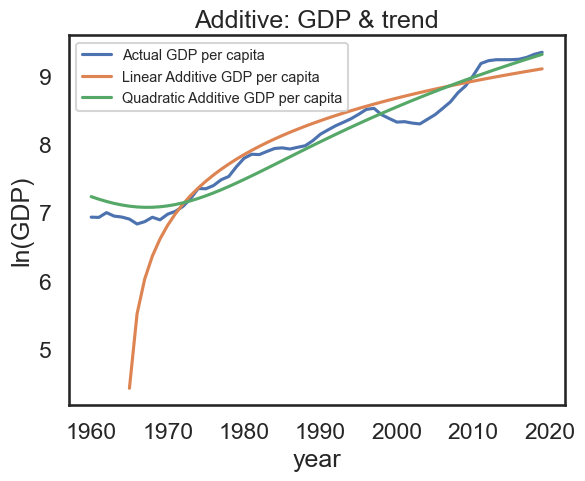

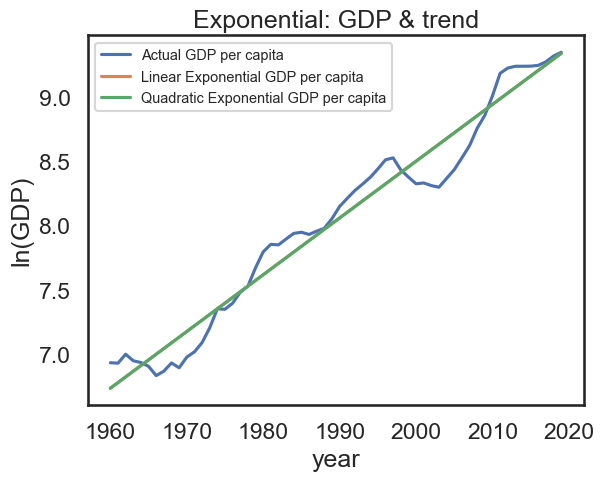

In [179]:
lw = 4

#Plot Additive Graph
plt.figure()
plt.plot(data['year'],np.log(data['rgdpe_pc']), label="Actual GDP per capita")
plt.plot(data['year'],yhat_add_lin, label="Linear Additive GDP per capita")
plt.plot(data['year'],yhat_add_quad, label="Quadratic Additive GDP per capita")

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive: GDP & trend")

#Plot Exponential Graph 
plt.figure()
plt.plot(data['year'],np.log(data['rgdpe_pc']), label="Actual GDP per capita")
plt.plot(data['year'],yhat_exp_lin, label="Linear Exponential GDP per capita")
plt.plot(data['year'],yhat_exp_quad, label="Quadratic Exponential GDP per capita")

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential: GDP & trend")

    year       rgdpna      emp          rnna     hc  TFP_alpha_0.25  \
0   1960  147538.9219  28.4990   762376.7500 1.1586       2584.6207   
1   1961  159648.6094  29.0606   765323.1875 1.1769       2768.4987   
2   1962  159406.1250  29.5694   764462.1875 1.1954       2674.1858   
3   1963  153244.6406  30.0887   756324.5000 1.2143       2463.5177   
4   1964  160370.2344  30.6187   751605.5625 1.2334       2537.4668   
5   1965  162256.9531  31.1592   747606.5000 1.2529       2497.7464   
6   1966  166785.0469  31.7103   747132.8125 1.2727       2507.0694   
7   1967  169049.1094  32.2722   740671.0000 1.2927       2476.3219   
8   1968  180746.7031  32.8447   743595.5000 1.3131       2615.4443   
9   1969  181878.7344  33.4280   751132.8750 1.3338       2542.4879   
10  1970  195463.0156  34.0220   769836.1875 1.3549       2685.1075   
11  1971  209155.2500  34.8577   796867.2500 1.3704       2803.4262   
12  1972  228844.8906  35.6180   832333.6875 1.3861       3014.1765   
13  19

Text(0.5, 1.0, 'Time Series of TFP')

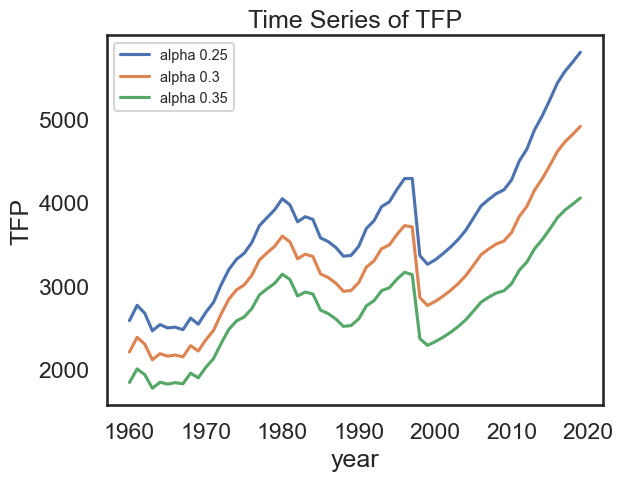

In [180]:
# Part B, calculating TFP 
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name='Data', header=0)

# Extract relevant variables in production function and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values in specified columns
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define a list of alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha and store the results in a dictionary
tfp_results = {}

for alpha in alpha_values:
    tfp = (1/(data_indonesia_b["emp"]*data_indonesia_b["hc"]))*(data_indonesia_b["rgdpna"]/(data_indonesia_b["rnna"])**alpha)**(1/(1-alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert the results dictionary to a DataFrame for better visualization
tfp_df = pd.DataFrame(tfp_results)

# Add the year column for reference
tfp_df["year"] = data_indonesia_b["year"]

# Merge the TFP DataFrame with the original Indonesia DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display the updated DataFrame
print(data_indonesia_b)

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

#labels
plt.xlabel("year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP")

In [181]:
# Part C, Growth Accounting
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Create a new column 'hL' that is labour multiplied by hc
data_indonesia_b["hL"] = data_indonesia_b["emp"] * data_indonesia_b["hc"]

# Display the updated DataFrame
print(data_indonesia_b)

# Initialise dataframe with NaNs
avg_growth_rates = pd.DataFrame(
    data = np.full((6, 4), np.nan),
    columns = ['Y growth', 'K growth', 'hL growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3 

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'hL', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values / data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values).flatten()

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['hL contribution'] = (1 - alpha) * (df_contribs_long['hL growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'hL contribution', 'A contribution']]

print(df_contribs_long)

    year       rgdpna      emp          rnna     hc  TFP_alpha_0.25  \
0   1960  147538.9219  28.4990   762376.7500 1.1586       2584.6207   
1   1961  159648.6094  29.0606   765323.1875 1.1769       2768.4987   
2   1962  159406.1250  29.5694   764462.1875 1.1954       2674.1858   
3   1963  153244.6406  30.0887   756324.5000 1.2143       2463.5177   
4   1964  160370.2344  30.6187   751605.5625 1.2334       2537.4668   
5   1965  162256.9531  31.1592   747606.5000 1.2529       2497.7464   
6   1966  166785.0469  31.7103   747132.8125 1.2727       2507.0694   
7   1967  169049.1094  32.2722   740671.0000 1.2927       2476.3219   
8   1968  180746.7031  32.8447   743595.5000 1.3131       2615.4443   
9   1969  181878.7344  33.4280   751132.8750 1.3338       2542.4879   
10  1970  195463.0156  34.0220   769836.1875 1.3549       2685.1075   
11  1971  209155.2500  34.8577   796867.2500 1.3704       2803.4262   
12  1972  228844.8906  35.6180   832333.6875 1.3861       3014.1765   
13  19

    year  labour_productivity
0   1960            5176.9945
1   1961            5493.6540
2   1962            5390.9188
3   1963            5093.0904
4   1964            5237.6644
5   1965            5207.3567
6   1966            5259.6419
7   1967            5238.2311
8   1968            5503.0674
9   1969            5440.9109
10  1970            5745.1916
11  1971            6000.2556
12  1972            6424.9876
13  1973            6763.4130
14  1974            7074.0346
15  1975            7355.4298
16  1976            7713.1818
17  1977            8220.7246
18  1978            8537.9919
19  1979            8881.7373
20  1980            9256.9685
21  1981            9350.6914
22  1982            9313.4043
23  1983            9706.6023
24  1984            9868.2618
25  1985            9649.7882
26  1986            9762.8904
27  1987            9824.8055
28  1988            9771.6431
29  1989            9973.0239
30  1990           10509.8048
31  1991           11341.8854
32  1992  

Text(0.5, 1.0, 'Time Series of TFP and Labour Productivity')

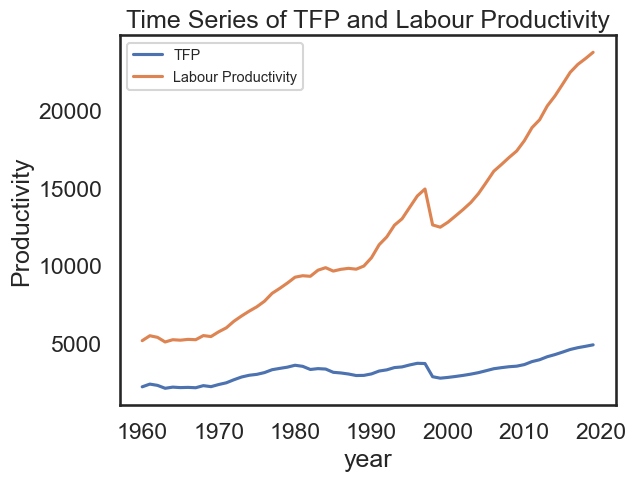

In [182]:
# Part D, Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
print(data_indonesia_b[["year", "labour_productivity"]])

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'],data_indonesia_b["labour_productivity"], label="Labour Productivity")

#labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP and Labour Productivity")
